First and foremost, it's crucial to understand that A/B testing is more complex than it might initially appear, especially for the implementation planned in this project. A high-quality A/B test requires proper experimental design, including well-defined test hypothesis, key metrics, and robust health-metrics (which ensure that overall system health or other critical areas do not degrade).

Then we should select of randomization units for A/B test. One of the main aspects is calculating the required sample size. This should be done with a predetermined power and significance level (alpha), ensuring that these thresholds are not adjusted once the test begins, as doing so can invalidate the results. As well what help to calculate necessary sample size for A/B test is determining the minimum detectable effect (MDE). And also this helps set expectations for the smallest effect size that the test is designed to detect.

Following the design phase, a 'research component' will be implemented, involving EDA and the execution of an A/B test. This test can be conducted using collected data, applying selected specific tests (parametric or non-parametric), or by employing resampling methods like the Permutation Test (Bootstrap). The objective of this testing is to evaluate the Null Hypothesis (H0), which states no significant difference between groups, against the Alternative Hypothesis (H1), which posits a significant difference. After completing this entire process, you can draw conclusions that will inform future product research.

Given all these factors, it's clear that designing and executing an A/B test can be a complex, time-consuming, and resource-intensive process. In this pet project, we will explore techniques for analyzing A/B test data sourced from Kaggle

# Import all necessary libraries

In [145]:
import os
import kagglehub

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import random
import scipy.stats as stats
from scipy.stats import shapiro
# parametric tests for ab testing
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

# non-parametric tests for ab testing
from scipy.stats import mannwhitneyu

As mentioned, the initial step involves proper test design. Tools like Evan Miller's A/B testing sample size calculator (https://www.evanmiller.org/ab-testing/sample-size.html) can assist in this. For this project, I will utilize Kaggle data to implement several hypotheses, focusing on practical experience in A/B testing. **Crucially, for any A/B test, it's essential to define a single, clear hypothesis, identify the metrics that will measure its impact, and select appropriate guardrail metrics to confirm that the change did not negatively affect other areas.**

In [19]:
# Download latest version
path = kagglehub.dataset_download("sergylog/ab-test-data")

In [38]:
# load data and take a first look
# data source - https://www.kaggle.com/datasets/sergylog/ab-test-data
df = pd.read_csv(os.path.join(path, os.listdir(path)[0]))
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [39]:
# detailed information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [40]:
# let's check unique values by each group
df.nunique()

,0
USER_ID,6324
VARIANT_NAME,2
REVENUE,101


# Data preprocessing

As observed, the number of unique users differs from the total number of records, which is problematic. This discrepancy indicates that a single user might appear in both the control and variant groups, or multiple times within the same group, potentially distorting the test results. This discrepancy indicates a single user might appear in both the control and variant groups, or multiple times within the same group, potentially distorting the test results. Therefore, the test should be canceled at this stage, and a corrected splitter implemented. However, if the test hypothesis and metric focus on significant changes in the average customer check, it may be acceptable for a user to have multiple records within a single group, provided they belong to only one group throughout the experiment. But again, as this project aims to improve practical skills in A/B testing, I'll proceed after some preprocessing and data research, despite the identified discrepancy. So, let's check this more detail.

In [41]:
temp = df.groupby("USER_ID")["VARIANT_NAME"].nunique().reset_index()
double_temp = temp[temp["VARIANT_NAME"] > 1]
print(f"Number of unique users what appear in each groups are {len(double_temp)}")
print(f"Number of unique users what appear in separate groups are {len(temp)-len(double_temp)}")

Number of unique users what appear in each groups are 1541
Number of unique users what appear in separate groups are 4783


In [42]:
double_df = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
(double_df / double_df.sum()).reset_index().rename(columns={"count": "percent_of_group"})

,VARIANT_NAME,percent_of_group
0,1,0.756325
1,2,0.243675


Here we can say that we have some problem with randomization because we have 24% of users in each A/B test group, we must inform about bad randomization split unit and choose another. If we don't do this, that will ruin all test.

In [53]:
# let's grab only users what exists in separate groups and save new dataframe
df = df[df["USER_ID"].isin(temp[temp["VARIANT_NAME"] == 1]["USER_ID"])]

Also, multiple existence of the one user within the same group can cause bias and incorrectness of the test. For example, we have one user who exists in a group of options and this user appears several times and each time he\she makes a purchase, so in this moment we can get incorrectness results, but these are rather inherent to the binomial distribution (buy/or not) and in the same time we focus on average check research. As a result, we will not remove such users for large amounts of data we just find out mean revenue by users. These issues should be considered during the A/B test planning period.

In [54]:
df = df.groupby(by=["USER_ID", "VARIANT_NAME"]).mean().reset_index()

# Short EDA

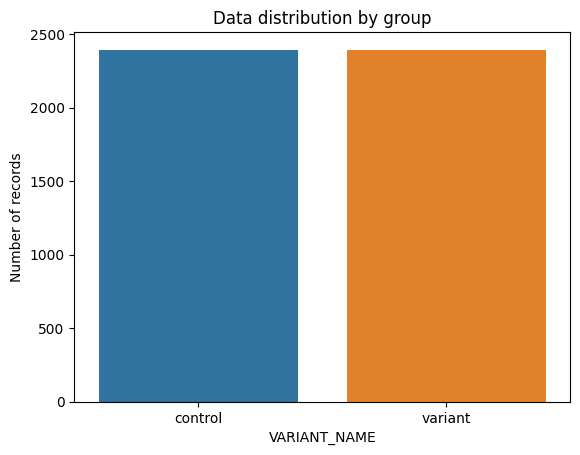

In [55]:
sns.countplot(data=df, x="VARIANT_NAME", hue="VARIANT_NAME")

plt.title("Data distribution by group")
plt.ylabel("Number of records")
plt.show()

see that in each group we approximately same number of records

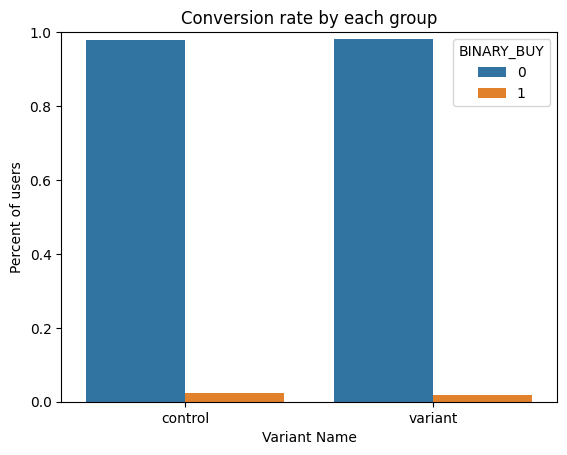

In [56]:
df["BINARY_BUY"] = df["REVENUE"].apply(lambda x: 1 if x > 0 else 0)
grouped_data = df.groupby("VARIANT_NAME")["BINARY_BUY"].value_counts(normalize=True).rename("percentage").reset_index()

sns.barplot(data=grouped_data, x="VARIANT_NAME", y="percentage", hue="BINARY_BUY")
plt.title("Conversion rate by each group")
plt.ylabel("Percent of users")
plt.xlabel("Variant Name")
plt.ylim(0, 1)
plt.show()

in this little project we comapre average revenue not conversion rate, means we don't really have to check this cnoversion, but I did it because wanna know how it differs between groups.

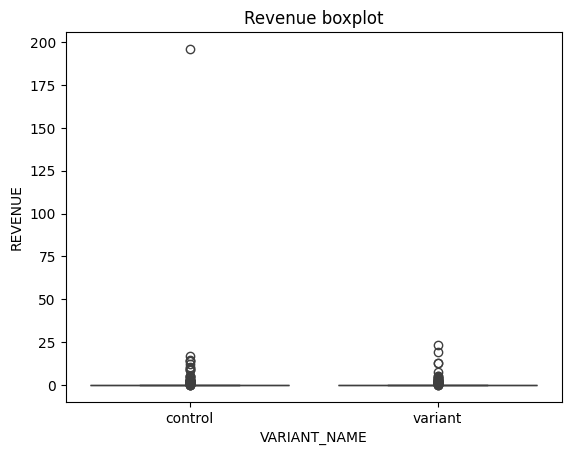

In [58]:
sns.boxplot(data=df, x="VARIANT_NAME", y="REVENUE")

plt.title("Revenue boxplot")
plt.show()

interesting, we have outlier in control group, let's check

In [59]:
df[df["VARIANT_NAME"] == "control"].sort_values(by="REVENUE", ascending=False).head()

,USER_ID,VARIANT_NAME,REVENUE,BINARY_BUY
1601,3342,control,196.01,1
2150,4445,control,17.05,1
1054,2166,control,14.66,1
1003,2059,control,14.24,1
962,1973,control,14.07,1


In [60]:
# just remove this value
df = df[df["USER_ID"] != 3342]

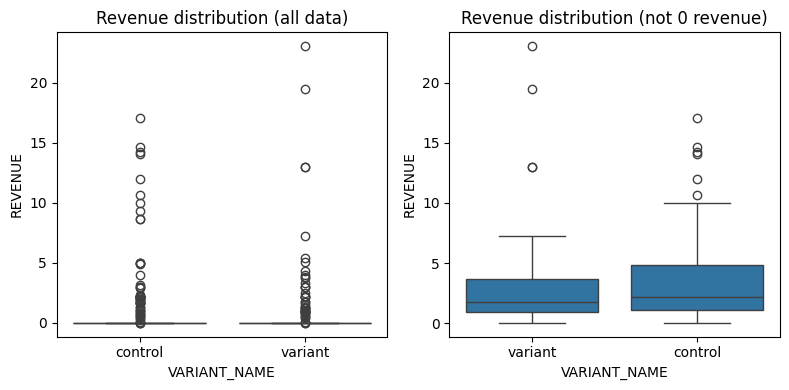

In [61]:
f, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.boxplot(ax=axes[0], data=df, x="VARIANT_NAME", y="REVENUE")
axes[0].set_title("Revenue distribution (all data)")

sns.boxplot(ax=axes[1], data=df[df["REVENUE"] > 0], x="VARIANT_NAME", y="REVENUE")
axes[1].set_title("Revenue distribution (not 0 revenue)")

plt.tight_layout()
plt.show()

The initial boxplot reveals that most users do not make a purchase, which significantly skews the overall revenue distribution towards zero. For this reason, considering the revenue distribution excluding zero-revenue users was necessary. This approach, however, is debatable and must be carefully considered during test planning. For instance, if our hypothesis directly concerns the average payment customer check, applying a test to all users (including non-buyers) would be misleading. Collecting data with one purpose and then retrospectively narrowing the scope to only paying users to achieve statistical significance is an incorrect practice and creates a false sense of a successful test.

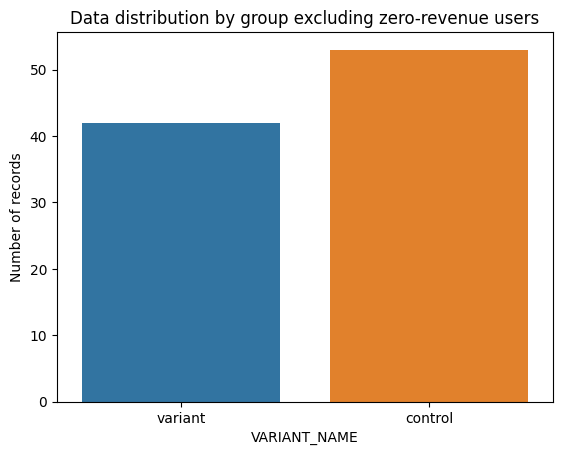

In [64]:
sns.countplot(data=df[df["REVENUE"] != 0], x="VARIANT_NAME", hue="VARIANT_NAME")

plt.title("Data distribution by group excluding zero-revenue users")
plt.ylabel("Number of records")
plt.show()

From here we don't know on what metrics for this A/B test we should specify, so let's try find as much useful data as possible.

In [62]:
# first of all let's check statistic by group
stat_group = df.groupby("VARIANT_NAME")["REVENUE"].agg(
    ["count", "sum", "mean", "median", "std"]).reset_index()
stat_group

,VARIANT_NAME,count,sum,mean,median,std
0,control,2389,200.744167,0.084029,0.0,0.847101
1,variant,2393,145.542333,0.060820,0.0,0.790772


here see that in variant group we have less total revenue and less revenue by user, but let's check situation in only payment users.

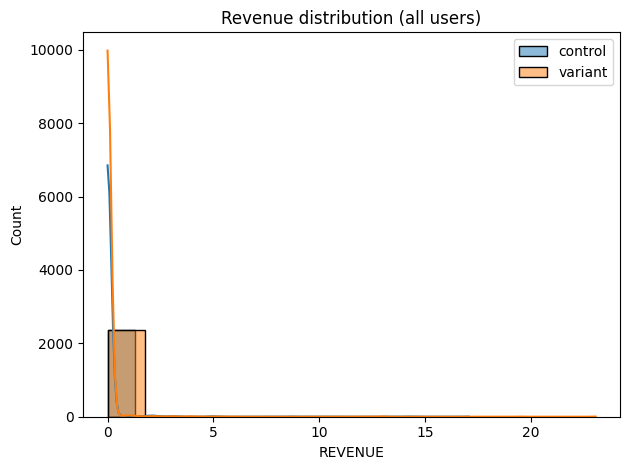

In [65]:
# let's see distribution of revenue

sns.histplot(data=df[df["VARIANT_NAME"] == "control"],
             x="REVENUE", kde=True, label="control")
sns.histplot(data=df[df["VARIANT_NAME"] == "variant"],
             x="REVENUE", kde=True, label="variant")
plt.title("Revenue distribution (all users)")

plt.tight_layout()
plt.legend()
plt.legend()
plt.show()

From this we can say sure that revenue don't have normal distribution, you can also check it with QQ-plot

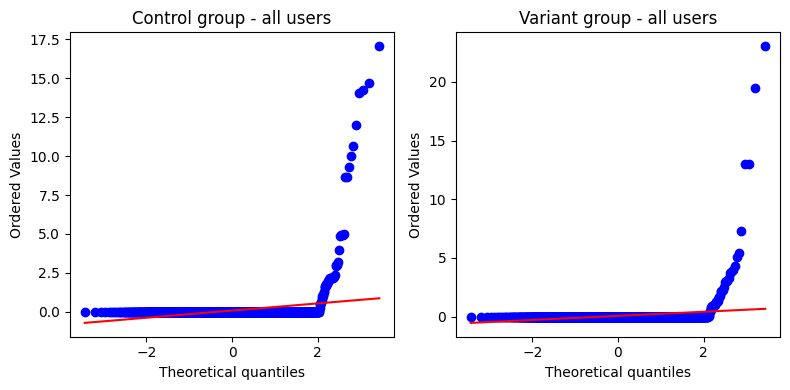

In [70]:
# let's make sure about it with QQplot
f, axes = plt.subplots(1, 2, figsize=(8, 4))

stats.probplot(df[df["VARIANT_NAME"] == "control"]["REVENUE"], dist="norm", plot=axes[0])
axes[0].set_title("Control group - all users")

stats.probplot(df[df["VARIANT_NAME"] == "variant"]["REVENUE"], dist="norm", plot=axes[1])
axes[1].set_title("Variant group - all users")

plt.tight_layout()
plt.show()

## Bootstrap for A/B testing

In [112]:
control_df = df[df["VARIANT_NAME"] == "control"]
variant_df = df[df["VARIANT_NAME"] == "variant"]

mean_distr_control = pd.Series([control_df["REVENUE"].sample(
    len(control_df), replace=True).mean() for _ in tqdm(range(10000))])

mean_distr_variant = pd.Series([variant_df["REVENUE"].sample(
    len(variant_df), replace=True).mean() for _ in tqdm(range(10000))])

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

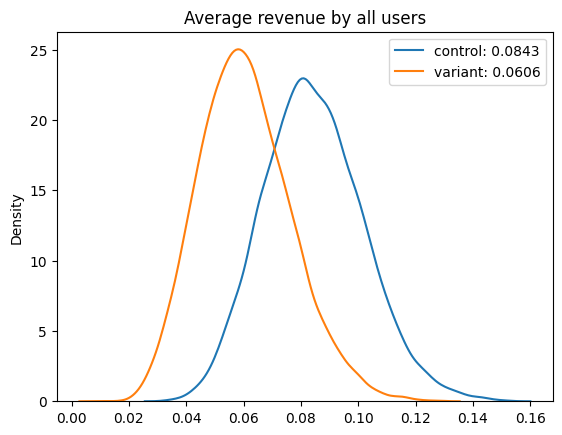

In [118]:
# let's compare means values between groups

sns.kdeplot(mean_distr_control, label=f"control: {np.round(np.mean(mean_distr_control), 4)}")
sns.kdeplot(mean_distr_variant, label=f"variant: {np.round(np.mean(mean_distr_variant), 4)}")

plt.title("Average revenue by all users")
plt.legend()
plt.show()

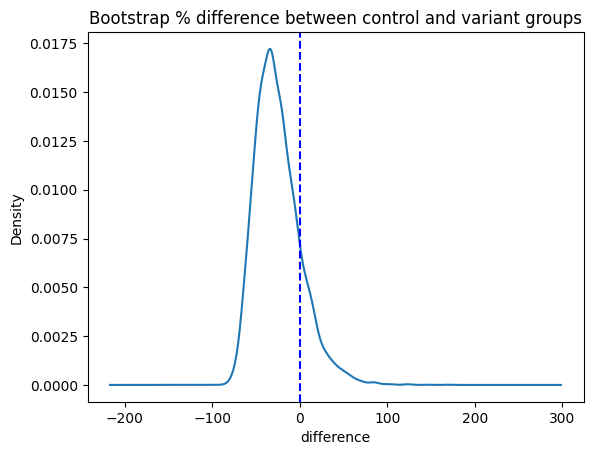

In [132]:
bootstrap_df = pd.DataFrame({'control': mean_distr_control, 'variant': mean_distr_variant})
bootstrap_df['diff'] = (bootstrap_df['variant'] / bootstrap_df['control'] - 1)*100

# Ploting the bootstrap % difference
ax = bootstrap_df['diff'].plot(kind = 'kde')
ax.set_xlabel('difference')
plt.axvline(0, color='blue', linestyle='--')
plt.title('Bootstrap % difference between control and variant groups')
plt.show()

The density plot includes zero, which indicates we cannot reject the null hypothesis (H0). This, in turn, implies there is no statistically significant difference.

In [129]:
#What is the probability that the difference is above 0%?
prob = (bootstrap_df['diff'] > 0).mean()

# Pretty printing the probability
print(f"{prob:.2%}")

15.44%


In [130]:
# This conclusion is further supported by the confidence interval, which includes zero
print(np.percentile(bootstrap_df['diff'], [2.5,97.5]))

[-64.55392637  37.09660933]


## A/A testing

A/A testing is crucial for verifying that the test splitter is working correctly and effectively. In an ideal scenario, a dedicated test (variant) group with no changes would be used to confirm no significant differences exist. For this practical project, however, I will perform an A/A test using a single data sample. As a result, I anticipate a False Positive Rate (FPR) of approximately 5%, as the analysis will be performed on two identical samples.

In [139]:
results = []
for _ in tqdm(range(10000)):
  aa_sample = df[df["VARIANT_NAME"] == "control"]["REVENUE"].sample(4782, replace=True)
  mask = np.random.rand(len(aa_sample)) < 0.5
  revenue_1 = aa_sample[mask]
  revenue_2 = aa_sample[~mask]

  _, pval = ttest_ind(revenue_1, revenue_2, equal_var=False)
  results.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

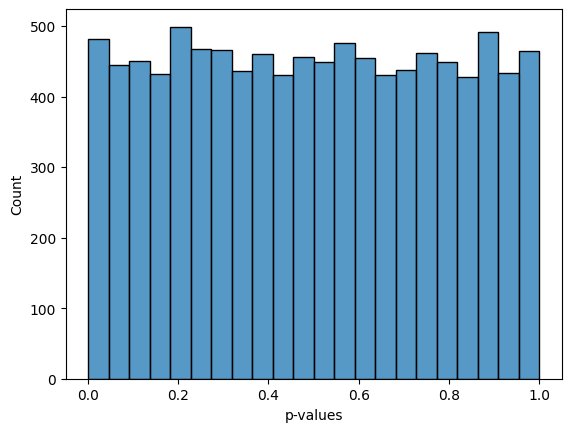

In [143]:
pvalues = pd.Series(results)

sns.histplot(pvalues)
plt.xlabel('p-values')
plt.show()

In [144]:
(pvalues < 0.05).mean()

np.float64(0.0516)

The result is very close to the alpha level.

## Stat test

Based on previous research, I would typically use the Mann-Whitney test; but, for this purpose, a universal script for quick A/B test calculation from Kaggle can also be utilized.

In [146]:
# A/B Testing Function - Quick Solution
# didn't wrote this, found on kaggle
# https://www.kaggle.com/code/bokshalex/user-aggregated-data-a-b-test

def AB_Test(dataframe, group, target):

    # Split A/B
    groupA = dataframe[dataframe[group] == "control"][target]
    groupB = dataframe[dataframe[group] == "test"][target]

    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True

    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True

        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True

    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05],
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")

    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]

    # Print Hypothesis
    #print("# A/B Testing Hypothesis")
    #print("H0: A == B")
    #print("H1: A != B", "\n")

    return temp

In [149]:
AB_Test(df, 'VARIANT_NAME', 'REVENUE')

/tmp/ipython-input-146-2318951265.py:13: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ntB = shapiro(groupB)[1] < 0.05
/tmp/ipython-input-146-2318951265.py:36: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest = stats.mannwhitneyu(groupA, groupB)[1]


,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,NaN,A/B groups are similar!


The result we obtained is similar to the bootstrap result.

# Conclusion

In this A/B testing project, we applied various methods and techniques, uncovering several important insights, such as issues with data collection, lack of proper randomization between groups, the presence of outliers, data distribution patterns, and the absence of significant differences between our metrics. There's nothing more to add; everything was explained earlier in the report.

When working with binary data, the following A/B test calculators are recommended as a solution:
* https://abtestguide.com/calc/
* https://www.evanmiller.org/ab-testing/chi-squared.html